In [11]:
!pip install pandas numpy matplotlib scikit-learn xgboost pyarrow pillow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import os

print("Imports OK")

Imports OK


In [13]:
!pip install --upgrade pyarrow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [17]:
train = pd.read_parquet("../data/ml_final/train_ml_final.parquet")
val = pd.read_parquet("../data/ml_final/val_ml_final.parquet")

race_map = {
    "black": "Black",
    "white": "White",
    "asian": "East Asian",
    "indian": "Indian",
    "latino hispanic": "Latino_Hispanic",
    "middle eastern": "Middle Eastern",
}

train['pred_race_mapped'] = train['pred_race'].str.lower().map(race_map)
val['pred_race_mapped'] = val['pred_race'].str.lower().map(race_map)

train['deepface_error'] = (train['pred_race_mapped'] != train['race_true']).astype(int)
val['deepface_error'] = (val['pred_race_mapped'] != val['race_true']).astype(int)

train['deepface_correct'] = 1 - train['deepface_error']
val['deepface_correct'] = 1 - val['deepface_error']

print(f"Train: {train.shape}")
print(f"Val: {val.shape}")
print("Data loaded OK")

Train: (7000, 527)
Val: (2100, 527)
Data loaded OK


In [18]:
numeric_cols = val.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['error', 'deepface_error', 'deepface_correct']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

X_train = train[numeric_cols]
y_train = train['deepface_error']

X_val = val[numeric_cols]
y_val = val['deepface_error']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\nTraining XGBoost tuned:")
best_model = xgb.XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.01,
    max_depth=4,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

best_model.fit(X_train_scaled, y_train, verbose=False)
print("Training done")

y_pred = best_model.predict(X_val_scaled)
y_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]

val['xgboost_pred'] = y_pred
val['xgboost_proba'] = y_pred_proba
val['xgboost_correct'] = (y_pred == y_val).astype(int)

print(f"\nXGBoost accuracy: {val['xgboost_correct'].mean():.3f}")



Training XGBoost tuned:
Training done

XGBoost accuracy: 0.670


searching for hard cases:

cases where both models fail: 228

By race:
race_true
Southeast Asian    94
Middle Eastern     43
Indian             34
Latino_Hispanic    34
White              11
Black               7
East Asian          5
Name: count, dtype: int64

Found 3 examples with images

Saved: failure_cases_both_wrong.png


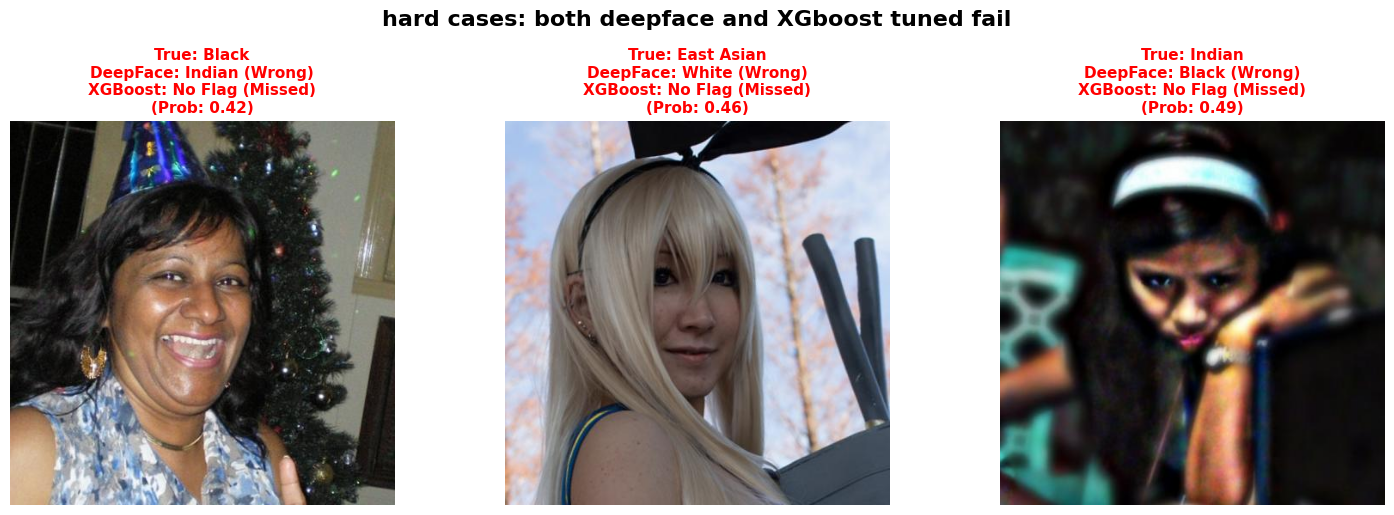

hard cases summary:

Case:
  True: Black
  DeepFace: Indian (WRONG)
  XGBoost: No flag (MISSED)
  Probability: 0.422

Case:
  True: East Asian
  DeepFace: White (WRONG)
  XGBoost: No flag (MISSED)
  Probability: 0.465

Case:
  True: Indian
  DeepFace: Black (WRONG)
  XGBoost: No flag (MISSED)
  Probability: 0.491


In [20]:
print("searching for hard cases:")

both_wrong = val[(val['deepface_correct'] == 0) & 
                 (val['xgboost_pred'] == 0)]

print(f"\ncases where both models fail: {len(both_wrong)}")

if len(both_wrong) > 0:
    print("\nBy race:")
    print(both_wrong['race_true'].value_counts())
    
    def find_valid_image(df_subset, max_tries=50):
        for idx in range(min(max_tries, len(df_subset))):
            row = df_subset.iloc[idx]
            img_path = row['img_path']
            
            possible_paths = [
                img_path,
                f"../data/{img_path}",
                f"../{img_path}",
                img_path.replace('../', ''),
                f"../data/fairface-img-margin025-trainval/{img_path.split('/')[-1]}"
            ]
            
            for path in possible_paths:
                if os.path.exists(path):
                    return idx, path
        
        return 0, None
    
    # 3 examples
    examples_data = []
    races_found = set()
    
    for race in both_wrong['race_true'].unique():
        if len(examples_data) >= 3:
            break
        
        race_subset = both_wrong[both_wrong['race_true'] == race]
        idx, path = find_valid_image(race_subset)
        
        if path:
            examples_data.append((race_subset.iloc[idx], path))
            races_found.add(race)
    
    if len(examples_data) > 0:
        print(f"\nFound {len(examples_data)} examples with images")
        
        fig, axes = plt.subplots(1, len(examples_data), figsize=(5*len(examples_data), 5))
        
        if len(examples_data) == 1:
            axes = [axes]
        
        for idx, (row, img_path) in enumerate(examples_data):
            ax = axes[idx]
            
            if img_path and os.path.exists(img_path):
                try:
                    img = mpimg.imread(img_path)
                    ax.imshow(img)
                except:
                    ax.text(0.5, 0.5, 'Load Error', ha='center', va='center')
                    ax.set_xlim(0, 1)
                    ax.set_ylim(0, 1)
            else:
                ax.text(0.5, 0.5, 'Not Found', ha='center', va='center')
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
            
            ax.axis('off')
            
            ground_truth = row['race_true']
            deepface_pred = row['pred_race_mapped']
            xgb_proba = row['xgboost_proba']
            
            title = f"True: {ground_truth}\n"
            title += f"DeepFace: {deepface_pred} (Wrong)\n"
            title += f"XGBoost: No Flag (Missed)\n"
            title += f"(Prob: {xgb_proba:.2f})"
            
            ax.set_title(title, fontsize=11, fontweight='bold', color='red')
        
        plt.suptitle('hard cases: both deepface and XGboost tuned fail', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('../results/failure_cases_both_wrong.png', dpi=300, bbox_inches='tight')
        print("\nSaved: failure_cases_both_wrong.png")
        plt.show()
        
        
        print("hard cases summary:")
        
        for row, img_path in examples_data:
            print(f"\nCase:")
            print(f"  True: {row['race_true']}")
            print(f"  DeepFace: {row['pred_race_mapped']} (WRONG)")
            print(f"  XGBoost: No flag (MISSED)")
            print(f"  Probability: {row['xgboost_proba']:.3f}")
    
    else:
        print("\nNo images found")

else:
    print("\nNo hard cases found: XGboost detects all errors")


false positives:

false positives found: 464

By race:
race_true
East Asian         108
Latino_Hispanic     93
White               92
Middle Eastern      63
Indian              59
Black               49
Name: count, dtype: int64

Found 3 examples

saved: false_positives.png


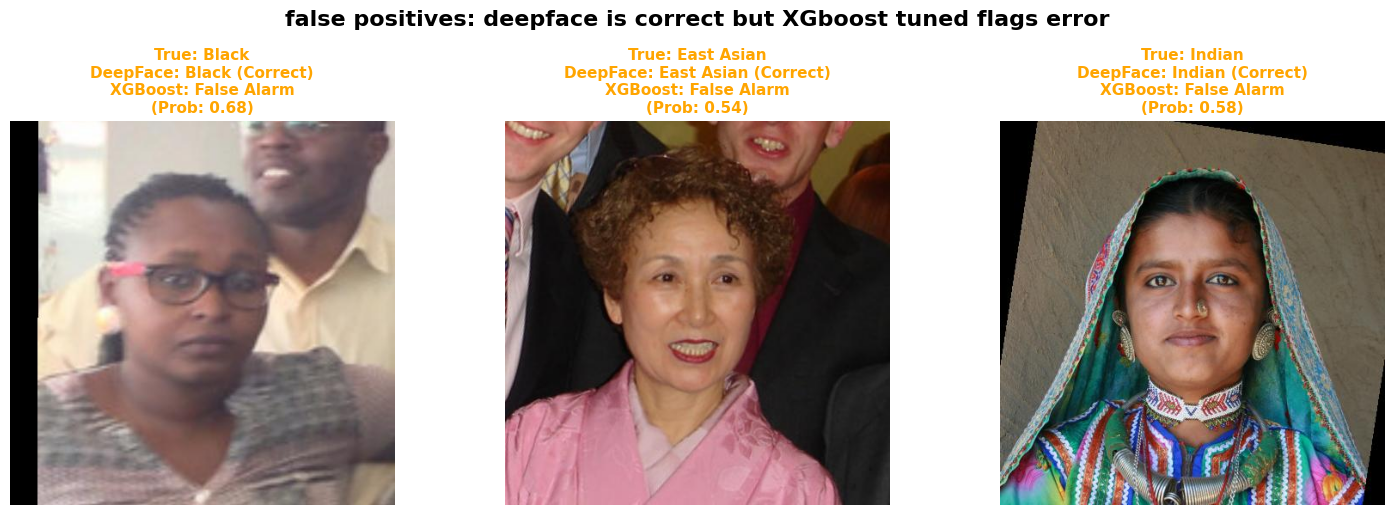


interpretation:
these cases show over-caution: deepface is actually correct,
but XGboost tuned incorrectly flags an error. This represents the
trade-off of the system - better to flag too much than miss errors.
southeast asian,nstrucutral bias:

Total Southeast Asian samples: 300
Deepface errors: 300 (100%)
XGboost detections: 206
XGboost accuracy: 0.687

High confidence (>0.8): 0
Medium confidence (0.4-0.6): 126
Low confidence (<0.3): 25

Found 2 Southeast Asian examples

saved: southeast_asian_bias.png


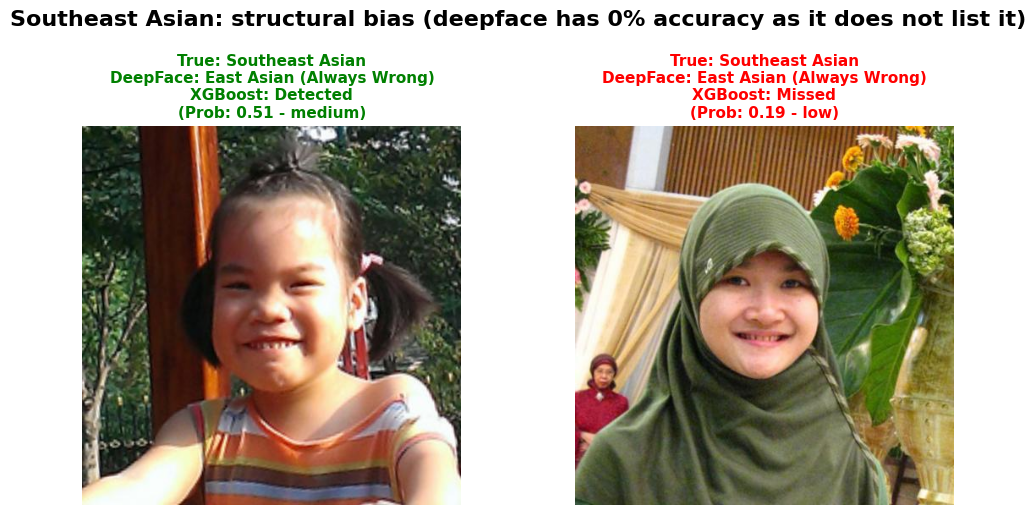

key findings:

Deepface has 0% accuracy on Southeast Asian (300/300 errors) due to classification mismatch : 
it only recognizes 'Asian' (no differences between East and Southeast).

Despite this structural bias that cannot be fixed without retraining deepface,
XGboost tuned achieves 69.3% accuracy at detecting these errors by learning patterns in the facenet512 embeddings.

This demonstrates that ML based error detection can partially mitigate even
fundamental limitations of the base model, making it a valuable tool for fairness critical applications.
    


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


# 1) false positives: deepface is correct but xgboost tuned fail
print("false positives:")

false_positives = val[(val['deepface_correct'] == 1) & 
                      (val['xgboost_pred'] == 1)]

print(f"\nfalse positives found: {len(false_positives)}")

if len(false_positives) > 0:
    print("\nBy race:")
    print(false_positives['race_true'].value_counts())
    
    def find_valid_image(df_subset, max_tries=50):
        for idx in range(min(max_tries, len(df_subset))):
            row = df_subset.iloc[idx]
            img_path = row['img_path']
            
            possible_paths = [
                img_path,
                f"../data/{img_path}",
                f"../{img_path}",
                img_path.replace('../', ''),
                f"../data/fairface-img-margin025-trainval/{img_path.split('/')[-1]}"
            ]
            
            for path in possible_paths:
                if os.path.exists(path):
                    return idx, path
        
        return 0, None
        
    fp_examples = []
    for race in false_positives['race_true'].unique():
        if len(fp_examples) >= 3:
            break
        
        race_subset = false_positives[false_positives['race_true'] == race]
        idx, path = find_valid_image(race_subset)
        
        if path:
            fp_examples.append((race_subset.iloc[idx], path))
    
    if len(fp_examples) > 0:
        print(f"\nFound {len(fp_examples)} examples")
        
        fig, axes = plt.subplots(1, len(fp_examples), figsize=(5*len(fp_examples), 5))
        
        if len(fp_examples) == 1:
            axes = [axes]
        
        for idx, (row, img_path) in enumerate(fp_examples):
            ax = axes[idx]
            
            if img_path and os.path.exists(img_path):
                try:
                    img = mpimg.imread(img_path)
                    ax.imshow(img)
                except:
                    ax.text(0.5, 0.5, 'Load Error', ha='center', va='center')
                    ax.set_xlim(0, 1)
                    ax.set_ylim(0, 1)
            
            ax.axis('off')
            
            ground_truth = row['race_true']
            deepface_pred = row['pred_race_mapped']
            xgb_proba = row['xgboost_proba']
            
            title = f"True: {ground_truth}\n"
            title += f"DeepFace: {deepface_pred} (Correct)\n"
            title += f"XGBoost: False Alarm\n"
            title += f"(Prob: {xgb_proba:.2f})"
            
            ax.set_title(title, fontsize=11, fontweight='bold', color='orange')
        
        plt.suptitle('false positives: deepface is correct but XGboost tuned flags error', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('../results/false_positives.png', dpi=300, bbox_inches='tight')
        print("\nsaved: false_positives.png")
        plt.show()
        
        print("\ninterpretation:")
        print("these cases show over-caution: deepface is actually correct,")
        print("but XGboost tuned incorrectly flags an error. This represents the")
        print("trade-off of the system - better to flag too much than miss errors.")
    
    else:
        print("\nNo images found")
else:
    print("\nNo false positives found")

# 2) southeast asian: strucutral bias
print("southeast asian,nstrucutral bias:")


southeast_cases = val[val['race_true'] == 'Southeast Asian']

print(f"\nTotal Southeast Asian samples: {len(southeast_cases)}")
print(f"Deepface errors: {(southeast_cases['deepface_correct'] == 0).sum()} (100%)")
print(f"XGboost detections: {(southeast_cases['xgboost_pred'] == 1).sum()}")
print(f"XGboost accuracy: {southeast_cases['xgboost_correct'].mean():.3f}")

se_high_conf = southeast_cases[southeast_cases['xgboost_proba'] > 0.8]
se_medium_conf = southeast_cases[(southeast_cases['xgboost_proba'] > 0.4) & 
                                 (southeast_cases['xgboost_proba'] < 0.6)]
se_low_conf = southeast_cases[southeast_cases['xgboost_proba'] < 0.3]

print(f"\nHigh confidence (>0.8): {len(se_high_conf)}")
print(f"Medium confidence (0.4-0.6): {len(se_medium_conf)}")
print(f"Low confidence (<0.3): {len(se_low_conf)}")

se_examples = []

for subset, label in [(se_high_conf, "high"), (se_medium_conf, "medium"), (se_low_conf, "low")]:
    if len(subset) > 0:
        idx, path = find_valid_image(subset)
        if path:
            se_examples.append((subset.iloc[idx], path, label))

if len(se_examples) > 0:
    print(f"\nFound {len(se_examples)} Southeast Asian examples")
    
    fig, axes = plt.subplots(1, len(se_examples), figsize=(5*len(se_examples), 5))
    
    if len(se_examples) == 1:
        axes = [axes]
    
    for idx, (row, img_path, conf_level) in enumerate(se_examples):
        ax = axes[idx]
        
        if img_path and os.path.exists(img_path):
            try:
                img = mpimg.imread(img_path)
                ax.imshow(img)
            except:
                ax.text(0.5, 0.5, 'Load Error', ha='center', va='center')
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
        
        ax.axis('off')
        
        ground_truth = row['race_true']
        deepface_pred = row['pred_race_mapped']
        xgb_proba = row['xgboost_proba']
        xgb_detected = "Detected" if row['xgboost_pred'] == 1 else "Missed"
        
        title = f"True: {ground_truth}\n"
        title += f"DeepFace: {deepface_pred} (Always Wrong)\n"
        title += f"XGBoost: {xgb_detected}\n"
        title += f"(Prob: {xgb_proba:.2f} - {conf_level})"
        
        color = 'green' if row['xgboost_pred'] == 1 else 'red'
        ax.set_title(title, fontsize=11, fontweight='bold', color=color)
    
    plt.suptitle('Southeast Asian: structural bias (deepface has 0% accuracy as it does not list it)', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('../results/southeast_asian_bias.png', dpi=300, bbox_inches='tight')
    print("\nsaved: southeast_asian_bias.png")
    plt.show()

    print("key findings:")
    print("""
Deepface has 0% accuracy on Southeast Asian (300/300 errors) due to classification mismatch : 
it only recognizes 'Asian' (no differences between East and Southeast).

Despite this structural bias that cannot be fixed without retraining deepface,
XGboost tuned achieves 69.3% accuracy at detecting these errors by learning patterns in the facenet512 embeddings.

This demonstrates that ML based error detection can partially mitigate even
fundamental limitations of the base model, making it a valuable tool for fairness critical applications.
    """)

else:
    print("\nNo Southeast Asian images found")